In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector
import geopandas as gpd
from geopy.geocoders import Nominatim
import folium
import us

In [2]:
db = mysql.connector.connect(
    host="localhost",
    user="ramsus",
    passwd="",
    database="superstore"
)

In [3]:
# Query to pandas dataframe
time_class = pd.read_sql_query("SELECT Ship_Mode, AVG(Delivery_Time) AS Delivery_Time FROM orders GROUP BY Ship_Mode ORDER BY Delivery_Time DESC;", db)

/tmp/ipykernel_153284/1164455581.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  time_class = pd.read_sql_query("SELECT Ship_Mode, AVG(Delivery_Time) AS Delivery_Time FROM orders GROUP BY Ship_Mode ORDER BY Delivery_Time DESC;", db)


<BarContainer object of 4 artists>

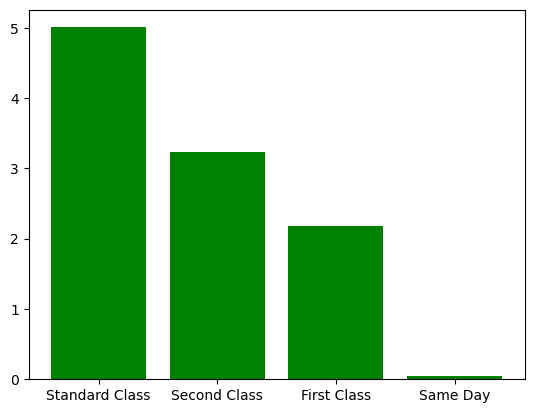

In [4]:
# create bar plot
plt.bar(time_class['Ship_Mode'], time_class['Delivery_Time'], color='green')

In [5]:
# delivery time by city
city_time = pd.read_sql_query("SELECT City, AVG(Delivery_Time) AS Delivery_Time FROM orders GROUP BY City ORDER BY Delivery_Time DESC;", db)

/tmp/ipykernel_153284/2387813628.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  city_time = pd.read_sql_query("SELECT City, AVG(Delivery_Time) AS Delivery_Time FROM orders GROUP BY City ORDER BY Delivery_Time DESC;", db)


In [6]:
city_time.head()
city_time.shape

(531, 2)

In [7]:
geolocator = Nominatim(user_agent='my_application')
geolocator.country_bias = 'us'


city_time['Coordinates'] = city_time['City'].apply(geolocator.geocode)
city_time['Latitude'] = city_time['Coordinates'].apply(lambda x: x.latitude if x != None else None)
city_time['Longitude'] = city_time['Coordinates'].apply(lambda x: x.longitude if x != None else None)

city_time.head()


,City,Delivery_Time,Coordinates,Latitude,Longitude
0,Waukesha,7.0,"(Waukesha, Waukesha County, Wisconsin, United ...",43.011678,-88.231481
1,Yucaipa,7.0,"(Yucaipa, San Bernardino County, California, 9...",34.033625,-117.043087
2,Citrus Heights,7.0,"(Citrus Heights, Sacramento County, CAL Fire N...",38.707125,-121.281061
3,Norfolk,7.0,"(Norfolk, England, United Kingdom, (52.666667,...",52.666667,1.000000
4,Conway,7.0,"(Conway County, Arkansas, United States, (35.2...",35.252200,-92.688894


In [8]:
# add a column with each city's state
city_time['State'] = city_time['Coordinates'].apply(
    lambda x: x.address.split(',')[-2].strip()
    if (x is not None and len(x.address.split(',')) >= 2) else None)
city_time.head()

,City,Delivery_Time,Coordinates,Latitude,Longitude,State
0,Waukesha,7.0,"(Waukesha, Waukesha County, Wisconsin, United ...",43.011678,-88.231481,Wisconsin
1,Yucaipa,7.0,"(Yucaipa, San Bernardino County, California, 9...",34.033625,-117.043087,92399
2,Citrus Heights,7.0,"(Citrus Heights, Sacramento County, CAL Fire N...",38.707125,-121.281061,California
3,Norfolk,7.0,"(Norfolk, England, United Kingdom, (52.666667,...",52.666667,1.000000,England
4,Conway,7.0,"(Conway County, Arkansas, United States, (35.2...",35.252200,-92.688894,Arkansas


In [9]:
# drop None and states that are only numbers

city_time = city_time.dropna()
city_time = city_time[city_time['State'].apply(lambda x: x.isnumeric() == False)]

city_time.head()

,City,Delivery_Time,Coordinates,Latitude,Longitude,State
0,Waukesha,7.0,"(Waukesha, Waukesha County, Wisconsin, United ...",43.011678,-88.231481,Wisconsin
2,Citrus Heights,7.0,"(Citrus Heights, Sacramento County, CAL Fire N...",38.707125,-121.281061,California
3,Norfolk,7.0,"(Norfolk, England, United Kingdom, (52.666667,...",52.666667,1.000000,England
4,Conway,7.0,"(Conway County, Arkansas, United States, (35.2...",35.252200,-92.688894,Arkansas
5,Danbury,7.0,"(Danbury, Western Connecticut Planning Region,...",41.394817,-73.454011,Connecticut


In [10]:
# get a list of all us states
us_states = [state.name for state in us.states.STATES]

# filter out non-states
city_time = city_time[city_time['State'].isin(us_states)]


In [11]:
#check number of rows
city_time.shape

(400, 6)

In [12]:
map_us = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

for index, row in city_time.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['City'] + ', ' + row['State'] + ': ' + str(row['Delivery_Time'])).add_to(map_us)

map_us


In [13]:
# create table from the dataframe
mycursor = db.cursor()

mycursor.execute("USE superstore")

mycursor.execute(
    "CREATE TABLE IF NOT EXISTS city_time (City VARCHAR(100), Delivery_Time FLOAT, Latitude FLOAT, Longitude FLOAT, State VARCHAR(100))"
)

for index, row in city_time.iterrows():
    mycursor.execute(
        "INSERT INTO city_time (City, Delivery_Time, Latitude, Longitude, State) VALUES (%s, %s, %s, %s, %s)",
        (row['City'], row['Delivery_Time'], row['Latitude'], row['Longitude'], row['State'])
    )



In [14]:
mycursor.execute("SELECT COUNT(*) FROM city_time")

myresult = mycursor.fetchall()

for x in myresult:
    print(x)


(400,)


In [15]:
db.commit()